In [37]:
# Following the tutorial but experimenting with altered initializations, 
# which the original tutorial doesn't.

# Conclude geometric conv net better than multilayer perceptron.
# The default initializations are not as good as the ones that I tried out!

# Tutorial found at: 
# https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX?usp=sharing

In [38]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

2.0.0+cu118
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [39]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [40]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [41]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


In [42]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


In [43]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


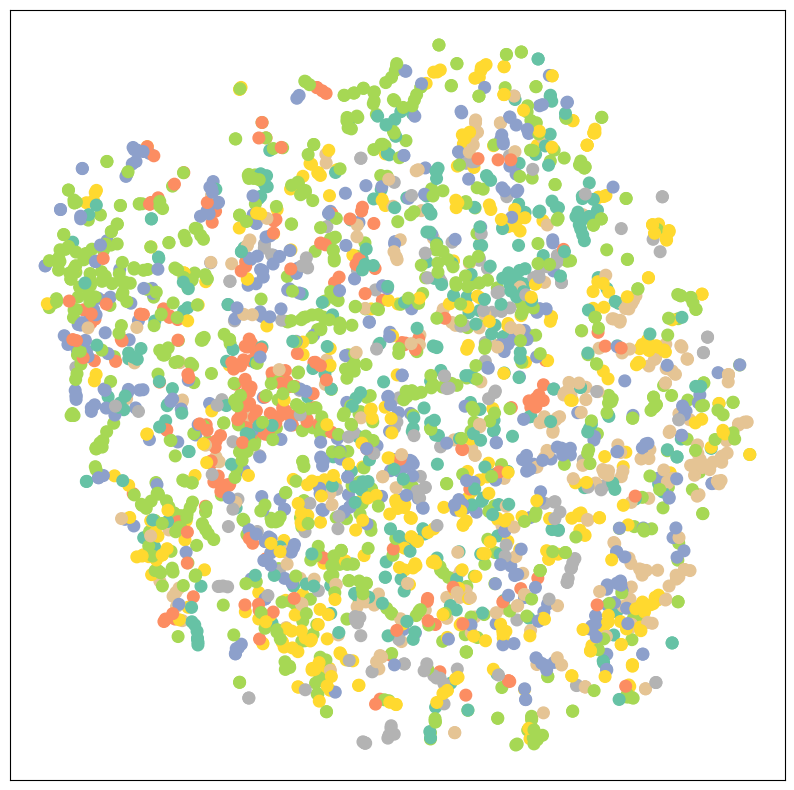

In [44]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [58]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss


def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc


for epoch in range(1, 111):
    loss = train()
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f},  Test: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9463,  Test: 0.2700
Epoch: 002, Loss: 1.9409,  Test: 0.2910
Epoch: 003, Loss: 1.9343,  Test: 0.2910
Epoch: 004, Loss: 1.9275,  Test: 0.3210
Epoch: 005, Loss: 1.9181,  Test: 0.3630
Epoch: 006, Loss: 1.9086,  Test: 0.4120
Epoch: 007, Loss: 1.9015,  Test: 0.4010
Epoch: 008, Loss: 1.8933,  Test: 0.4020
Epoch: 009, Loss: 1.8808,  Test: 0.4180
Epoch: 010, Loss: 1.8685,  Test: 0.4470
Epoch: 011, Loss: 1.8598,  Test: 0.4680
Epoch: 012, Loss: 1.8482,  Test: 0.5180
Epoch: 013, Loss: 1.8290,  Test: 0.5440
Epoch: 014, Loss: 1.8233,  Test: 0.5720
Epoch: 015, Loss: 1.8057,  Test: 0.5910
Epoch: 016, Loss: 1.7966,  Test: 0.6080
Epoch: 017, Loss: 1.7825,  Test: 0.6300
Epoch: 018, Loss: 1.7617,  Test: 0.6450
Epoch: 019, Loss: 1.7491,  Test: 0.6520
Epoch: 020, Loss: 1.7310,  Test: 0.6560
Epoch: 021, Loss: 1.7147,  Test: 0.6570
Epoch: 022, Loss: 1.7056,  Test: 0.6640
Epoch: 023, Loss: 1.6954,  Test: 0.6770
Epoch: 024, Loss: 1.6697,  Test: 0.6950
Epoch: 025, Loss: 1.6538,  Test: 0.7140


In [46]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8160


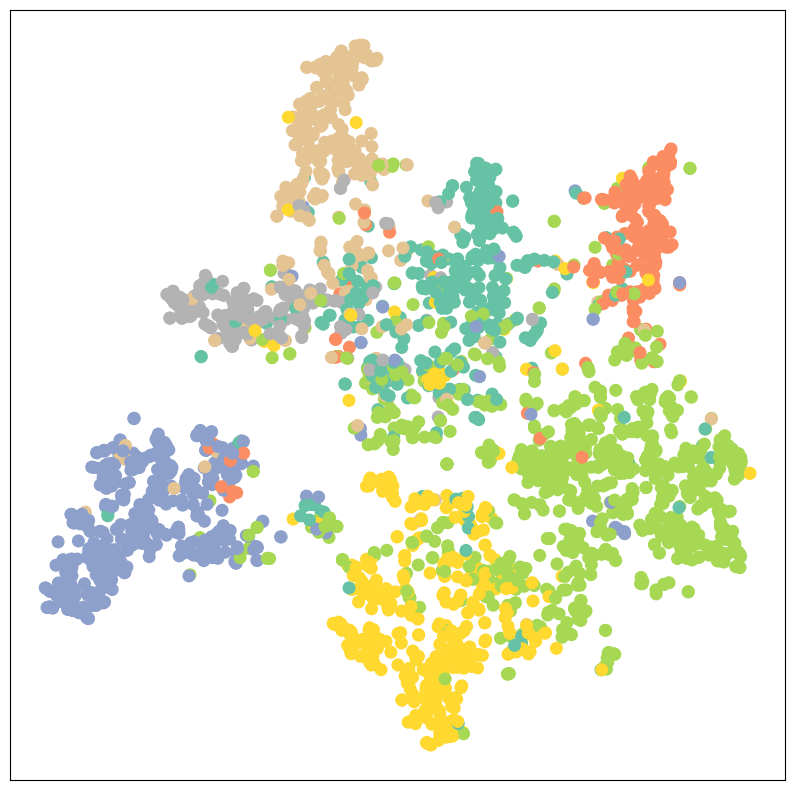

In [47]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [48]:
# how does changing initialisations change things? 
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv


class GCN_1(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

        # Initialize parameters
        for conv in [self.conv1, self.conv2]:
            for name, param in conv.named_parameters():
                if 'weight' in name:
                    nn.init.kaiming_uniform_(param, nonlinearity='relu')
                elif 'bias' in name:
                    nn.init.zeros_(param)

        with torch.no_grad():
          for name, param in self.conv2.named_parameters():
              if 'weight' in name:
                  print(param)
                  param = param * 0.01
              elif 'bias' in name:
                  print(param)
                  nn.init.zeros_(param)
        print(self.conv2.parameters())


    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN_1(hidden_channels=16)
print(model)
print(dir(model2))

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0.], requires_grad=True)
Parameter containing:
tensor([[-4.8306e-01, -2.1951e-01, -4.8419e-01, -2.2044e-01,  1.0830e-01,
         -2.1055e-01,  3.1787e-01, -4.9946e-01,  5.5827e-01, -4.4896e-01,
          3.2595e-01, -4.8146e-02, -3.6336e-01,  5.0134e-01,  4.0456e-01,
          4.2071e-01],
        [-8.7684e-02, -4.2513e-01, -2.5057e-01,  4.2343e-01, -3.6012e-01,
         -2.9180e-01, -1.0065e-01,  5.0688e-01,  2.3880e-01,  2.5991e-01,
          4.8403e-01, -5.9437e-01,  4.4662e-01,  4.1726e-01,  4.0310e-01,
          3.0949e-01],
        [ 8.2819e-02,  1.4959e-01, -4.7237e-01, -2.9778e-01, -2.3309e-01,
          1.5607e-01, -2.9511e-01,  4.3896e-01,  5.3138e-01, -2.2778e-01,
         -5.0052e-01,  1.3121e-01, -3.6600e-01, -2.3724e-01, -3.5967e-01,
         -3.5630e-01],
        [-5.1871e-01,  7.7161e-02,  5.2296e-01, -1.0791e-01,  2.4086e-01,
         -3.0811e-01, -5.9893e-01,  2.9520e-01,  1.1576e-01, -2.4492e-04,
          5.1926

In [59]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN_1(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss



def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc


for epoch in range(1, 111):
    loss = train()
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test: {test_acc:.4f}')


<IPython.core.display.Javascript object>

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0.], requires_grad=True)
Parameter containing:
tensor([[-4.8306e-01, -2.1951e-01, -4.8419e-01, -2.2044e-01,  1.0830e-01,
         -2.1055e-01,  3.1787e-01, -4.9946e-01,  5.5827e-01, -4.4896e-01,
          3.2595e-01, -4.8146e-02, -3.6336e-01,  5.0134e-01,  4.0456e-01,
          4.2071e-01],
        [-8.7684e-02, -4.2513e-01, -2.5057e-01,  4.2343e-01, -3.6012e-01,
         -2.9180e-01, -1.0065e-01,  5.0688e-01,  2.3880e-01,  2.5991e-01,
          4.8403e-01, -5.9437e-01,  4.4662e-01,  4.1726e-01,  4.0310e-01,
          3.0949e-01],
        [ 8.2819e-02,  1.4959e-01, -4.7237e-01, -2.9778e-01, -2.3309e-01,
          1.5607e-01, -2.9511e-01,  4.3896e-01,  5.3138e-01, -2.2778e-01,
         -5.0052e-01,  1.3121e-01, -3.6600e-01, -2.3724e-01, -3.5967e-01,
         -3.5630e-01],
        [-5.1871e-01,  7.7161e-02,  5.2296e-01, -1.0791e-01,  2.4086e-01,
         -3.0811e-01, -5.9893e-01,  2.9520e-01,  1.1576e-01, -2.4492e-04,
          5.1926

In [50]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8170


In [ ]:
# better loss with the altered initialisation, certainly by epoch 100, and 109 -
# 110 seems a little strange. Final accuracy is marginally better, but not 
# significantly, although much higher accuracy at Epoch 100 - argument for fiddling
# with learning rate? Or for early stopping? Are the dark greens, below, more clearly separated than they
# are above? 

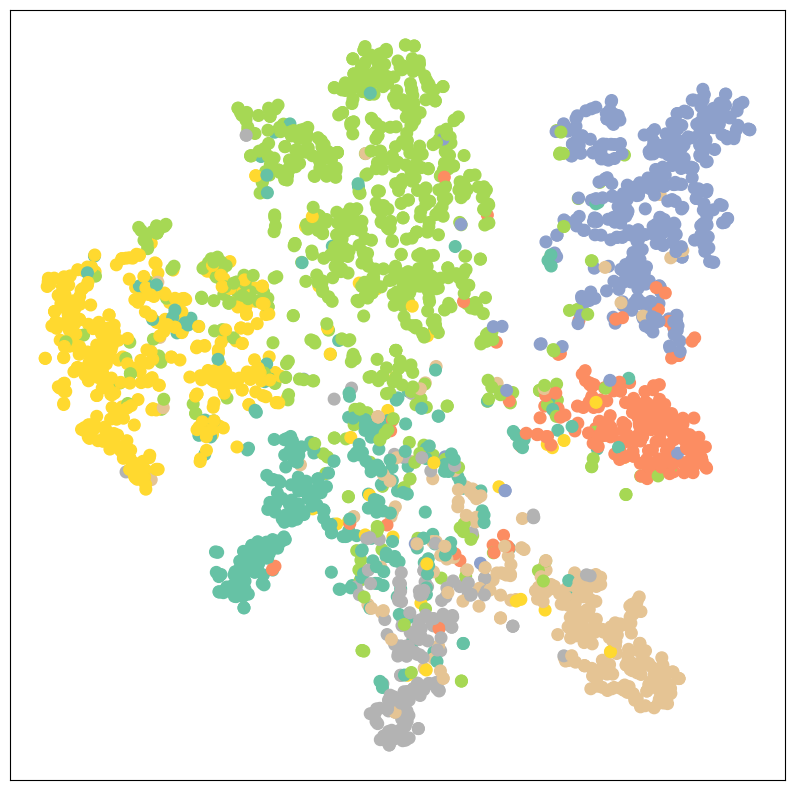

In [51]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [55]:
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(in_channels = dataset.num_features, 
                             out_channels = hidden_channels, 
                             heads = heads, 
                             dropout=0.6)  
        self.conv2 = GATConv(in_channels = hidden_channels * heads, 
                             out_channels =  dataset.num_classes, 
                             heads = 1)   

#class GATConv(in_channels: Union[int, Tuple[int, int]], out_channels: 
#              int, heads: int = 1, concat: bool = True, negative_slope: 
#              float = 0.2, dropout: float = 0.0, 
#              add_self_loops: bool = True, edge_dim: Optional[int] = None, 
#  fill_value: Union[float, Tensor, str] = 'mean', bias: bool = True, **kwargs)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc


for epoch in range(1, 111):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)
Epoch: 001, Loss: 1.9443, Val: 0.3640, Test: 0.4040
Epoch: 002, Loss: 1.9344, Val: 0.4180, Test: 0.4640
Epoch: 003, Loss: 1.9284, Val: 0.5440, Test: 0.5710
Epoch: 004, Loss: 1.9194, Val: 0.6360, Test: 0.6550
Epoch: 005, Loss: 1.9117, Val: 0.6600, Test: 0.6870
Epoch: 006, Loss: 1.9050, Val: 0.6940, Test: 0.7100
Epoch: 007, Loss: 1.8965, Val: 0.7320, Test: 0.7240
Epoch: 008, Loss: 1.8868, Val: 0.7460, Test: 0.7400
Epoch: 009, Loss: 1.8722, Val: 0.7440, Test: 0.7480
Epoch: 010, Loss: 1.8616, Val: 0.7460, Test: 0.7470
Epoch: 011, Loss: 1.8518, Val: 0.7400, Test: 0.7570
Epoch: 012, Loss: 1.8433, Val: 0.7480, Test: 0.7600
Epoch: 013, Loss: 1.8348, Val: 0.7500, Test: 0.7650
Epoch: 014, Loss: 1.8125, Val: 0.7580, Test: 0.7750
Epoch: 015, Loss: 1.8122, Val: 0.7860, Test: 0.7810
Epoch: 016, Loss: 1.8001, Val: 0.7880, Test: 0.7840
Epoch: 017, Loss: 1.7762, Val: 0.7960, Test: 0.7910
Epoch: 018, Loss: 1.7677, Val: 0.8000

In [ ]:
#final accuracy worse than GCNconv, although loss is much lower. 